In [23]:
import pandas as pd
import pymongo
import matplotlib.pyplot as plt

# MongoDB to DataFrame

In [26]:
# Mongodb 불러오기
import pymongo

# mongodb 연결
conn = pymongo.MongoClient()

# DB접근
db = conn['crawling_review']

# collection 접근
collection = db['movies']

In [43]:
# DataFrame
doc = collection.find_one()
data = pd.DataFrame(doc, columns=['star','comment'])
data.sample(10)

,star,comment
9437,10,ㅈㄴ재밋노명작이다 무조건봐야하노
4731,1,갑자기 도게자 ㄹㅇㅋㅋ
659,10,야만의 시대를 잘 고증했다. 재미 있는 것은 진실을 밝히자는 영화가 아니다. 당시의...
1270,10,
7449,9,고스트 버스터즈 속 장면들을 오마주한 장면들도 가득해 찾아보는 재미도 쏠쏠~
5271,10,7000년을 낭비하는 이터널즈와14000년을 기막히게 사용하는 맨 프럼 어스
3760,8,왜 재미없다고 한건지;; 괜찮게 본영화유체이탈이 되는 이유가 억지스럽긴함
1832,10,80년도에나 나왓어야 할 영화감독이 신세계 범죄도시 팬인듯 ㅋ
9597,1,돈 아까워욥.. 재미업ㄱ음
7006,10,재밌었어요 기대이상이였어요! 초반에는 살짝 지루하지만 중반부터 액션 보는 재미가 있...


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   star     9990 non-null   object
 1   comment  9990 non-null   object
dtypes: object(2)
memory usage: 156.2+ KB


In [ ]:
# data tpye 변경


In [45]:
# 평점 7 이상 = 긍정(1)
data_pos = data[data['star']>=7]
data_pos['label'] = 1
data_pos

TypeError: '>=' not supported between instances of 'str' and 'int'

In [7]:
# 평점 6 이하 = 부정(0)
data_neg = data[data['평점']<7]
data_neg['label'] = 0
data_neg

C:\Users\User\AppData\Local\Temp/ipykernel_19796/4173353538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_neg['label'] = 0


,Unnamed: 0,index,평점,리뷰,label
2,2,2,1,대체... 이게 뭐죠?,0
4,4,4,1,보는 내가 유체이탈할뻔 보다가 나온 영화는 처음임답답하고 주인공 본인도 몰라 답답한...,0
6,6,6,1,고양이가 그렇게 불쌍하시면 데려가서 키우세요. 집없이 밖에서 벌벌떠는 고양이들이 불...,0
7,7,7,2,연출 연기 스토리 전부 잘못된 영화,0
9,9,9,1,중국 자본인 게 너무 티나서 아쉽다.,0
...,...,...,...,...,...
9980,9980,9980,5,재미없음,0
9982,9982,9982,3,"필름을 드라마 찍을때 사용하는 방식으로 찍엇노??? 장혁,유오성 너무 아깝다. 감독...",0
9984,9984,9984,4,강원도사투리가 넘쎄서 영화스타일이랑 안어울림. 뭐라고하는지 원...,0
9985,9985,9985,6,님의 하드캐리,0


In [14]:
# 데이터 합치고 필요없는 column 제거
df = pd.concat([data_pos,data_neg], ignore_index=True)
df.drop(['Unnamed: 0'],axis=1 ,inplace=True)

In [19]:
df.sample(10)

,index,평점,리뷰,label
5727,8201,10,배우들 연기 너무 좋았고 재미있게 보았어요~한번 더 보고 싶어요,1
1603,2260,10,중세 전쟁영환줄 알고 봤더만 전혀 다른 영화네 긴 러닝타임이 전혀 느껴지지않는 영화...,1
4585,6554,10,인생 최고의 영화..ㅜㅜ,1
2602,3667,10,황정민 이정재 박정민 캬 ... 말이 필요하나요 너무 재밌었어요 ㅠㅠ 사랑해 ??,1
6096,8729,10,와.. 이 작품이후로 아무것도 만드신게 없네요.. 왜일까??왜일까? 왜?,1
6320,9063,7,티비판 편집본이라 흐름이 끊기는 순간이 있는 거 빼고는 괜찮습니다,1
8992,6812,5,확실히 공포도는 낮음후반부 반전 밝혀질떄의 연출이 좋았다,0
4370,6252,10,살아계실적에 잘하자.. 엄마에게..♡,1
8139,4130,6,기대보다는 덜영상미는 디즈니답게 엄청좋으나감동은 코코보다 덜한듯,0
5227,7492,9,볼거리도 많고 유쾌합니다 재미있게 집중해서 봤어요,1


<AxesSubplot:>

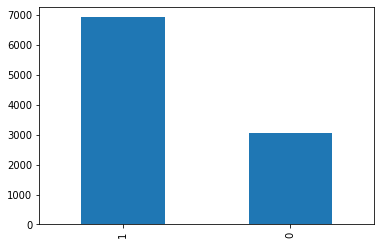

In [24]:
# label 비율 확인
df['label'].value_counts().plot.bar()